Based on this paper https://doi.org/10.1088/2634-4386/ac1b75

In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [27]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
from edamame import *
from tqdm.notebook import tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
import pickle 
import _pickle as cPickle
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object

In [9]:

dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Results/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [10]:
name2='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/300nw_2_modules_separated_10sets_NWN.pkl'
NWN_separate=decompress_pickle(name2)

In [11]:
module=NWN_separate[0][0][1]

In [ ]:
a = module['G']


# b = nx.union(a,a, rename=('a-', 'b-'))
# b.add_edge('a-148', 'b-148')

# plt.figure()
# nx.draw_networkx(b,with_labels=True,node_size=500)

# plt.figure()
# a=nx.relabel_nodes(a, { n: str(n) if n==0 else 'c-'+str(n) for n in  a.nodes })
# c = nx.union(a,b)
# c.add_edge('c-114','b-114')
# pos=nx.kamada_kawai_layout(c)
# nx.draw_networkx(c,pos=pos,with_labels=True,node_size=500)
# plt.show()

### MEMORY CAPACITY TASK (MC)

In [ ]:
# FUNCTIONS
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0
    
def get_MC_Voltsweep(Graph,signal,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
#     np.random.seed(seed)
    stimulus=[]
    stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal))#signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = signal#signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
#                 electrodes=elecs[-2:],
                contactMode = 'farthest',
                findFirst=False, disable_tqdm=True)    
    nodesList=[]
    for i in range(len(Graph.nodes)):
        nodesList.append(i)
#     nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
#     compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, nodesList
    else:
        return np.sum(mcRAND)
    

def get_MC_Voltsweep_deep(Graph,amp = 2, voltageInputs=[],elecs=[], dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
    if elecs:
        electrodes=elecs
        contactMode='preSet'
        for volt in voltageInputs:
            stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=volt))#signal_expand(np.random.random(1000)*2*volt-volt, dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    else:
        electrodes=None
        contactMode='farthest'
        stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand((np.random.random(1000)*2*amp-amp), dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
#                 biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
                electrodes=electrodes,
                contactMode = contactMode,
                findFirst=False, disable_tqdm=True)    
    nodesList=[]
    for i in range(len(Graph.nodes)):
        nodesList.append(i)
#     nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
#     compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, nodesList
    else:
        return np.sum(mcRAND)

In [239]:
#SINGLE NETWORK:

numRep=100#number of repeats
seeds=np.random.randint(1000,size=numRep) #random seeds
MC_single=np.zeros(numRep)
for i in tqdm(range(numRep)):
    MC_single[i],sim_single,G,node_list=get_MC_Voltsweep(a,amp=2,return_sim=True,seed=seeds[i])

In [240]:
print(np.std(MC_single))
np.mean(MC_single)

7.468066703924522


13.015578578206078

In [238]:
print(np.std(MC_single))
np.mean(MC_single)

7.505754367017882


13.228458606502226

In [273]:
# WIDE NETWORKS:
sim_wide=[None]*3
MC_wide=[None]*3
MC_final_wide=[]
amp=2
for i in tqdm(range(numRep)):
    #generate signals:
    np.random.seed(seeds[i])
    signal=signal_expand(np.random.random(1000)*2*amp-amp, dur)
    MC_wide[0],sim_wide[0],G,node_list=get_MC_Voltsweep(a,signal,amp=amp,return_sim=True)
    MC_wide[1],sim_wide[1],G,node_list=get_MC_Voltsweep(a,signal,amp=amp,return_sim=True)
    MC_wide[2],sim_wide[2],G,node_list=get_MC_Voltsweep(a,signal,amp=amp,return_sim=True)
    dur = 1
    mc=[]
    node_list=node_list*3
    for k in (range(dur, len(node_list)*dur, dur)):
        transient = 100
        signal = np.hstack((sim_wide[0].stimulus[0].signal[transient:],sim_wide[1].stimulus[0].signal[transient:],sim_wide[2].stimulus[0].signal[transient:]))
        wire_voltage = np.vstack((sim_wide[0].wireVoltage[transient:],sim_wide[1].wireVoltage[transient:],sim_wide[2].wireVoltage[transient:]))
        T, N = wire_voltage.shape
        #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
        lhs = wire_voltage[k:,node_list]
        rhs = signal[:-k]

        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
        result = np.matmul(lhs, weight)
        mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))
    print(np.sum(mc))
    MC_final_wide.append(np.sum(mc))

67.92852106789746
9.482952115462645
65.42397324975369
30.243052768292806
58.64129090651578
58.83104991576349
4.061460219684862
6.001595679866405
15.489246784786385
50.64241839826893
8.643435068952368
28.19921717290258
52.86858247754792
49.00831697405513
12.282836045274152
7.838880159686495
70.48280446718519
43.76820215363127
13.402576990152077
67.13655842902358
46.09616136361893
45.521355876473564
53.26190780580927
66.48959245544202
48.03687844848794
4.994323388535214
72.4803182129534
21.63937507506738
10.582872984190962
56.620072930135905
18.55448042940755
59.68542307533647
39.07065887956772
38.30697490842002
17.099097692441887
18.910787174983913
54.03793736146523
66.96009439987154
35.355118114874955
50.837944435762985
13.916479481426746
41.406022173784265
14.588372055610641
56.8927720496541
62.760439489836145
16.567461481331932
10.934808591822595
10.60608654470357
25.190798201936406
2.246185995026247
68.27636947497341
13.446412809163245
55.1152234902697
32.63832192913037
24.898562613

In [275]:
print(np.std(MC_final_wide))
np.mean(MC_final_wide)

21.835875019535507


37.105106505036254

In [283]:
#DEEP NETWORKS:

sim_deep=[None]*3
MC_deep=[None]*3
MC_final_deep=[]
numInputs=10 

#3 sub reservoirs with 10 INPUTS
for i in tqdm(range(numRep)):
    
    MC_deep[0],sim_deep[0],G,node_list=get_MC_Voltsweep_deep(a,amp=2,return_sim=True,seed=seeds[i])
    
    #list of all wires
    temp=list(range(len(sim_deep[0].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(sim_deep[0].sources)):
        temp.remove(sim_deep[0].sources[j])
    temp.remove(sim_deep[0].drains[0])
    sampleIdx=np.random.choice(temp,10,replace=False)

    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(sim_deep[0].wireVoltage.T[idx])
    drains=sim_deep[0].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))

    MC_deep[1],sim_deep[1],G,node_list=get_MC_Voltsweep_deep(a,amp=2,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])
    
    #list of all wires
    temp=list(range(len(sim_deep[1].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(sim_deep[1].sources)):
        temp.remove(sim_deep[1].sources[j])
    temp.remove(sim_deep[1].drains[0])
    sampleIdx=np.random.choice(temp,10,replace=False)
    
    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(sim_deep[1].wireVoltage.T[idx])
    drains=sim_deep[1].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))
    
    MC_deep[2],sim_deep[2],G,node_list=get_MC_Voltsweep_deep(a,amp=2,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])
    
    node_list=node_list*3
    
    dur = 1
    mc=[]
    for k in (range(dur, len(node_list)*dur, dur)):

        signal = np.hstack((sim_deep[0].stimulus[0].signal[transient:],sim_deep[0].stimulus[0].signal[transient:],sim_deep[0].stimulus[0].signal[transient:])) #reconstruct only the ORIGINAL signal
        wire_voltage = np.vstack((sim_deep[0].wireVoltage[transient:],sim_deep[1].wireVoltage[transient:],sim_deep[2].wireVoltage[transient:]))
        T, N = wire_voltage.shape
        #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
        lhs = wire_voltage[k:,node_list]
        rhs = signal[:-k]

        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
        result = np.matmul(lhs, weight)
        mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))
    print(np.sum(mc))
    MC_final_deep.append(np.sum(mc))

25.678128065760504
6.492546302610975
23.69065444631299
15.23132034060098
29.432485970988296
22.821011309412654
3.4483387381162447
4.6237010323796435
9.354901741173705
19.813195903511158
7.428860752839322
13.627502394927618
21.208931009552636
20.84199042427342
8.478469465212655
7.154640353128128
25.564897174830342
18.44193060444508
9.084385993550637
26.099927199064275
19.41073436941005
19.959611650174686
23.469106862441617
25.6828852410833
19.855250274367805
3.823606923329991
26.696535070292434
11.146314760652668
7.139535812657128
22.578557793513134
10.042292840350495
22.90994403137373
24.970668215617472
15.94674430777556
9.806540266259429
9.413065353869273
22.697022681594383
24.390093224008364
15.679211477460097
20.643559399816017
8.980871667108659
17.446112289470722
10.13233187579516
22.203085537485457
24.860685604937974
8.92368668816231
8.36098054831851
7.416503375870379
13.36612997431913
1.8339323584545646
25.283630051659767
8.631372743109523
22.679499284663045
15.246275593996064
14

In [284]:
print(np.std(MC_final_deep))
np.mean(MC_final_deep)

7.187487992088258


16.27397539344189

In [ ]:
#DEEP NETWORKS:

sim_deep_50=[None]*3
MC_deep_50=[None]*3
MC_final_deep_50=[]
numInputs=50

#3 sub reservoirs with 50 INPUTS
for i in tqdm(range(numRep)):
    
    MC_deep_50[0],sim_deep_50[0],G,node_list=get_MC_Voltsweep_deep(a,amp=2,return_sim=True,seed=seeds[i])
    
    #list of all wires
    temp=list(range(len(sim_deep_50[0].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(sim_deep_50[0].sources)):
        temp.remove(sim_deep_50[0].sources[j])
    temp.remove(sim_deep_50[0].drains[0])
    sampleIdx=np.random.choice(temp,numInputs,replace=False)

    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(sim_deep_50[0].wireVoltage.T[idx])
    drains=sim_deep_50[0].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))

    MC_deep_50[1],sim_deep_50[1],G,node_list=get_MC_Voltsweep_deep(a,amp=2,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])
    
    #list of all wires
    temp=list(range(len(sim_deep_50[1].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(sim_deep_50[1].sources)):
        temp.remove(sim_deep_50[1].sources[j])
    temp.remove(sim_deep_50[1].drains[0])
    sampleIdx=np.random.choice(temp,numInputs,replace=False)
    
    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(sim_deep_50[1].wireVoltage.T[idx])
    drains=sim_deep_50[1].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))
    
    MC_deep_50[2],sim_deep_50[2],G,node_list=get_MC_Voltsweep_deep(a,amp=2,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])
    
    node_list=node_list*3
    
    dur = 1
    mc=[]
    for k in (range(dur, len(node_list)*dur, dur)):

        signal = np.hstack((sim_deep_50[0].stimulus[0].signal[transient:],sim_deep_50[0].stimulus[0].signal[transient:],sim_deep_50[0].stimulus[0].signal[transient:])) #reconstruct only the ORIGINAL signal
        wire_voltage = np.vstack((sim_deep_50[0].wireVoltage[transient:],sim_deep_50[1].wireVoltage[transient:],sim_deep_50[2].wireVoltage[transient:]))
        T, N = wire_voltage.shape
        #     node_list = np.random.choice(range(0, N), n_outs, replace = False)
        lhs = wire_voltage[k:,node_list]
        rhs = signal[:-k]

        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0] #output weights (voltage) and input (voltage) using least squares regression
        result = np.matmul(lhs, weight)
        mc.append((np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result)))
    print(np.sum(mc))
    MC_final_deep_50.append(np.sum(mc))

30.744073304140926
8.522507673522723
31.359583735017708
25.879808075096882
42.37643316110764
31.08335135577393
3.5162061741082713
5.236521101502133
14.190315562429204
33.75411340648597
8.841532213611874
24.053682805913024
29.963947550461018
34.5665570339658
12.997386990484731
7.675216450107435
32.78663498930202
30.767062026213818
14.13159582836595
35.41523830417724
32.43577532640345


In [ ]:
print(np.std(MC_final_deep_50))
np.mean(MC_final_deep_50)

In [278]:
stds=np.hstack((np.std(MC_single),np.std(MC_final_wide),np.std(MC_final_deep)))

In [279]:
import pandas as pd
df=pd.DataFrame({'Single':{'Mean':np.mean(MC_single)},'Wide':{'Mean':np.mean(MC_final_wide)},'Deep':{'Mean':np.mean(MC_final_deep)}})

Text(0, 0.5, 'MC')

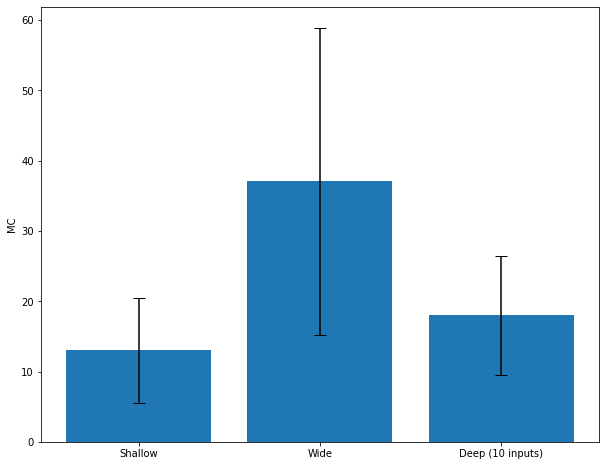

In [281]:
fig,ax=plt.subplots(1,figsize=(10,8))
plt.bar(np.arange(df.shape[1]), df.mean(), yerr=stds, capsize=6)
ax.set_xticks(np.arange(df.shape[1]))
ax.set_xticklabels(['Shallow','Wide','Deep (10 inputs)'])
ax.set_ylabel('MC')

### NARMA TASK

In [ ]:
def get_NARMA_deep(Graph,amp = 2, u=[], voltageInputs=[],elecs=[], dt = 0.01, dur = 1, hist = 30, shift = 2,n_outs = 100, init_state = None, return_sim = False,seed=42):
    ampName=str(amp).replace('.','p')
    np.random.seed(seed)
    stimulus=[]
    
    N = Graph.number_of_nodes#Connectivity.number_of_wires
    
    if elecs:
        electrodes=elecs
        contactMode='preSet'
        for volt in voltageInputs:
            stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=volt))#signal_expand(np.random.random(1000)*2*volt-volt, dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    else:
        electrodes=None
        contactMode='farthest'
        y = np.zeros(len(u))
        stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=u))#signal_expand((np.random.random(1000)*2*amp-amp), dur)))
        stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    
    for i in range(hist, len(u)):
#         y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(y[i-hist:i]) + 1.5*u[i-hist]*u[i-1] + 0.001
#         y[i] = 0.1*y[i-1] + 0.004*y[i-1]*np.sum(y[i-hist:i]) + 2*u[i-hist]*u[i-1] + 0.1
        y[i] = 0.01*y[i-1] + 0.0004*y[i-1]*np.sum(y[i-hist:i]) + 1.5*u[i-hist]*u[i-1] + shift    
    
    wire_voltage = simRAND.wireVoltage
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    node_list=[]
    for i in range(len(Graph.nodes)):
        node_list.append(i)

    k = 200
    lhs = wire_voltage[k:,node_list]
    rhs = y[k:]
    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
    result = np.matmul(lhs, weight)
    acc = 1-getRNMSE(result, rhs)
    
    if return_sim:
        return acc, simRAND, u, node_list
    else:
        return acc, u, node_list

In [ ]:
amp=2;dur=1;hist=30,shift=2;
u = signal_expand(np.random.random(1000)*amp, dur)
for i in tqdm(range(numRep)):

    NARMA_deep[0],simNARMA_deep[0],u,node_list=get_NARMA_deep(a,u=u,amp=amp,return_sim=True,seed=seeds[i])

    #list of all wires
    temp=list(range(len(simNARMA_deep[0].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(simNARMA_deep[0].sources)):
        temp.remove(simNARMA_deep[0].sources[j])
    temp.remove(simNARMA_deep[0].drains[0])
    sampleIdx=np.random.choice(temp,numInputs,replace=False)

    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(simNARMA_deep[0].wireVoltage.T[idx])
    drains=simNARMA_deep[0].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))

    NARMA_deep[1],simNARMA_deep[1],u,node_list=get_NARMA_deep(a,u=u,amp=amp,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])

    #list of all wires
    temp=list(range(len(simNARMA_deep[1].wireVoltage.T)))
    #remove wires that are sources or drains:
    for j in range(len(simNARMA_deep[1].sources)):
        temp.remove(simNARMA_deep[1].sources[j])
    temp.remove(simNARMA_deep[1].drains[0])
    sampleIdx=np.random.choice(temp,numInputs,replace=False)

    wireVoltages=[]
    for idx in sampleIdx:
        wireVoltages.append(simNARMA_deep[1].wireVoltage.T[idx])
    drains=simNARMA_deep[1].drains[0]
    electrodes=list(np.hstack((sampleIdx,drains)))

    NARMA_deep[2],simNARMA_deep[2],u,node_list=get_NARMA_deep(a,u=u,amp=amp,voltageInputs=wireVoltages,elecs=electrodes,return_sim=True,seed=seeds[i])

    wire_voltage = np.vstack((simNARMA_deep[0].wireVoltage[transient:],simNARMA_deep[1].wireVoltage[transient:],simNARMA_deep[2].wireVoltage[transient:]))
    node_list=node_list*3
    for i in range(hist, len(u)):
#         y[i] = 0.2*y[i-1] + 0.004*y[i-1]*np.sum(y[i-hist:i]) + 1.5*u[i-hist]*u[i-1] + 0.001
#         y[i] = 0.1*y[i-1] + 0.004*y[i-1]*np.sum(y[i-hist:i]) + 2*u[i-hist]*u[i-1] + 0.1
        y[i] = 0.01*y[i-1] + 0.0004*y[i-1]*np.sum(y[i-hist:i]) + 1.5*u[i-hist]*u[i-1] + shift       
    k = 200
    lhs = wire_voltage[k:,node_list]
    rhs = y[k:]
    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
    result = np.matmul(lhs, weight)
    NARMA_deep_final.append(1-getRNMSE(result, rhs))


### MACKEY-GLASS TIME-SERIES

In [ ]:
def get_MG(Connectivity, amp = 1, 
          dt = 0.01, dur = 1, 
          hist = 20, shift = 2,
          n_outs = 10, init_state = None, 
          return_sim = False):
#     np.random.seed()
    N = Connectivity.number_of_wires
    y = mkg_generator(1000, 100*dt, 50)
    temp_sim = runSim(Connectivity, T = 1000*dt, dt = dt,
                start_state =  init_state,
                biasType = 'Custom', customSignal = y, 
                junctionMode = 'tunneling', 
                contactMode = 'farthest',
                findFirst=False, disable_tqdm=True)
    
    wire_voltage = temp_sim.wireVoltage
    node_list = np.random.choice(range(0, N), n_outs, replace = False)
    lhs = wire_voltage[:-hist,node_list]
    rhs = y[hist:]
    weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
    result = np.matmul(lhs, weight)
    acc = 1-getRNMSE(result, rhs)
    

    if return_sim:
        return acc, temp_sim
    else:
        return acc